<h1><center> Predictive statistics on the I-SPY1 Clinical Trial</center></h1>

### 0. Load modules and clean data

In [1]:
# import custom modules wrote by julio
import seaborn as sns
import pandas as pd
RANDOM_STATE = 42; # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from ispy1 import predictive_statistics

from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
from imblearn import over_sampling as os
from imblearn import pipeline as pl

# reload modules without restartign the kernel (makes development easier)
import importlib
importlib.reload(predictive_statistics);

df = pd.read_csv('./data/I-SPY_1_clean_data.csv')
df.head(2)

,SUBJECTID,age,White,ER+,PR+,HR+,Bilateral,Right_Breast,MRI_LD_Baseline,MRI_LD_1_3dAC,MRI_LD_Int_Reg,MRI_LD_PreSurg,Alive,Survival_length,RFS,RFS_code,PCR,RCB
0,1001,38.73,Yes,Yes,No,Yes,No,No,88.0,78.0,30.0,14.0,No,1264,751,1,No,2.0
1,1002,37.79,Yes,Yes,Yes,Yes,No,Yes,29.0,26.0,66.0,16.0,No,1155,1043,1,No,3.0


<h1><center> Prediction of categorical outcomes</center></h1>

### 1. Prepare Imbalanced Learning pipeline

In [2]:

def unbalanced_learning(X,y,classifier):
    # http://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf
    
    # define Kappa scorer
    scorer = metrics.make_scorer(metrics.cohen_kappa_score)
    
    # ADASYN for inbalanced learning, this will over sample the class wit the fewest number of cases
    adasyn = os.ADASYN(random_state=RANDOM_STATE)

    # create pipeline
    pipeline_classifier = pl.make_pipeline(adasyn, classifier)
    
    # optimize over this variable
    train_scores, test_scores, ideal_par = predictive_statistics.validation_curve(pipeline_classifier,
                                                                       X, y, "adasyn__k",scorer,
                                                                       parameter_range = range(1,20),
                                                                       c_v = 5)
    # plot validation                                                                                                             
    predictive_statistics.plot_validation_curve(train_scores, test_scores,
                                     param_range = range(1,20), title = "Validation Curve with ADASYN",
                                                                     xlabel = 'K neighbor', ylabel = 'Kappa') 
    
    # change parameter into optimal value
    pipeline_classifier.set_params(adasyn__k = ideal_par);
    
    
    # standard classifier
    standard_classifier = classifier.fit(X,y)
    
    return pipeline_classifier, standard_classifier
    
def plot_feature_importance(X,labels, TreeClassifier, title =''):
    predictor_num = np.arange(0,X.shape[1]);
    
    importance = TreeClassifier.feature_importances_
    index = np.argsort(importance, axis = 0)
    
    plt.barh(predictor_num, importance[index]);
    plt.yticks(index, labels);
    plt.title(title);
    plt.show()
    

### 2. clean, load, and format data

In [3]:
X_df = df.iloc[:,0:11]
X_df.head(2)

# allocate age alone (size issue)

# allocate continous predictors
mri_predictors = ['MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
X_mri = df[mri_predictors].values

# allocate clinical predictors
clinical_predictors = ['age','White', 'ER+', 'PR+', 'HR+'];
X_clinical = pd.pandas.get_dummies(df[clinical_predictors], drop_first=True).values

# allocate a single variable X
X = np.concatenate( (X_clinical, X_mri), axis=1)

#
df.head(3)

,SUBJECTID,age,White,ER+,PR+,HR+,Bilateral,Right_Breast,MRI_LD_Baseline,MRI_LD_1_3dAC,MRI_LD_Int_Reg,MRI_LD_PreSurg,Alive,Survival_length,RFS,RFS_code,PCR,RCB
0,1001,38.73,Yes,Yes,No,Yes,No,No,88.0,78.0,30.0,14.0,No,1264,751,1,No,2.0
1,1002,37.79,Yes,Yes,Yes,Yes,No,Yes,29.0,26.0,66.0,16.0,No,1155,1043,1,No,3.0
2,1003,49.83,Yes,Yes,Yes,Yes,No,No,50.0,64.0,54.0,46.0,Yes,2387,2387,0,No,3.0


<h1><center> Prediction of categorical outcomes</center></h1>

## 1.0 Pathological Complete Response (PCR)

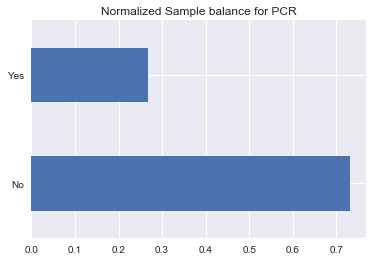

In [4]:
# How inbalanced is the sample
outcome ='PCR'
df[outcome].value_counts(normalize = True).plot.barh(); plt.title('Normalized Sample balance for ' + outcome);

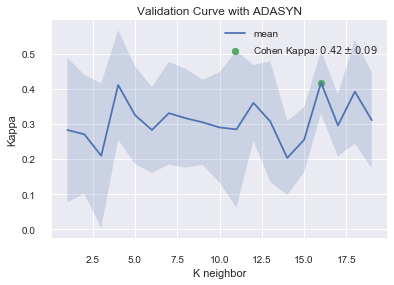

In [5]:
# allocate  outcome 
outcome = 'PCR'
y = predictive_statistics.labels_to_numbers(df, outcome)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# choose classifier (DecisionTreeClassifier)
clf = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)

# unbalanced learning
clf_opt, clf_std= unbalanced_learning(X_train,y_train,clf)

# train with optimized parameters and predict
#clf_opt.fit(X_train, y_train)
yhat = clf_opt.predict(X_test)

In [6]:
# performance
predictive_statistics.classification_report(y_test, yhat)

------------------------------------------------------------
Observed Performance
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.78      0.91      0.84        32
          1       0.40      0.20      0.27        10

avg / total       0.69      0.74      0.70        42

------------------------------------------------------------
Performance assuming  41 observations belong to the largest class
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.76      0.97      0.85        32
          1       0.00      0.00      0.00        10

avg / total       0.58      0.74      0.65        42



### what is the importance of each predictor?

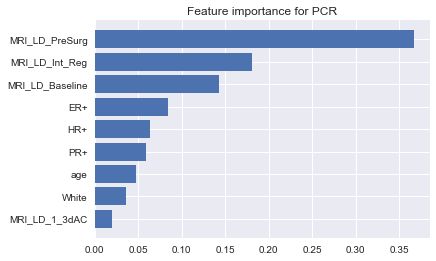

In [7]:
labels = clinical_predictors + mri_predictors 
plot_feature_importance(X,labels, clf_opt.steps[1][1],'Feature importance for ' + outcome)

# How much does ADASYN help ?

In [8]:
from sklearn.calibration import CalibratedClassifierCV

# function to estimate ROC curve and AUC using calibrated propabilities
def roc_curve_calibrated_prob(classifier, Xtrain, ytrain, Xtest, ytest, positive_class = 1):
    # calibrated probability
    CF = CalibratedClassifierCV( base_estimator = classifier, method='sigmoid', cv=10)
    CF.fit(Xtrain,ytrain)
    score = CF.predict_proba(Xtest)
    
    tpr, fpr, _ = metrics.roc_curve(ytest, score[:,1], pos_label = positive_class, drop_intermediate = False)
    
    return tpr, fpr, metrics.auc(tpr,fpr)


In [9]:
# estimate metrics for unbalanced learning
tpr_ul, fpr_ul, auc_ul = roc_curve_calibrated_prob(clf_opt, X_train, y_train, X_test, y_test, positive_class = 1)
print(auc_ul)
# estimate metrics for standard classifier
tpr_st, fpr_st, auc_st = roc_curve_calibrated_prob(clf_std, X_train, y_train, X_test, y_test, positive_class = 1)
print(auc_st)

0.6390625
0.6296875


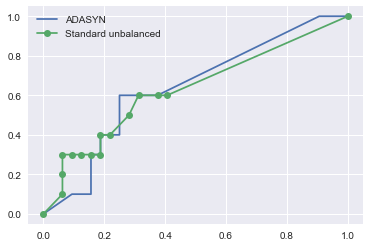

In [10]:
# plot
plt.plot(tpr_ul,fpr_ul,'-')
plt.plot(tpr_st,fpr_st,'o-')
plt.legend(['ADASYN','Standard unbalanced'])

## 2.0  Survival (`Alive`)

In [11]:
# allocate  outcome 
outcome = 'Alive'
y = predictive_statistics.labels_to_numbers(df, outcome)

# extended clinical predictors
clinical_predictors = ['PCR','age','White', 'ER+', 'PR+', 'HR+'];
X_clinical = pd.pandas.get_dummies(df[clinical_predictors], drop_first=True).values

# allocate a single variable X
X = np.concatenate( (X_clinical, X_mri), axis=1)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

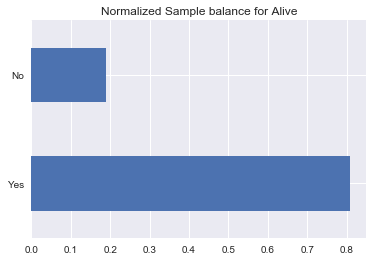

In [12]:
# How inbalanced is the sample
df[outcome].value_counts(normalize = True).plot.barh(); plt.title('Normalized Sample balance for ' + outcome);

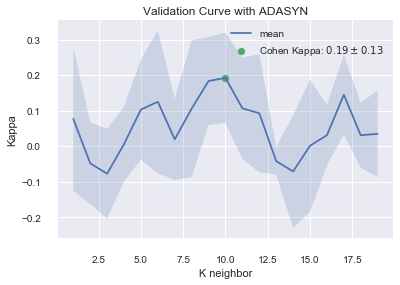

In [13]:
# unbalanced learning
clf_opt, clf_std= unbalanced_learning(X,y,clf)

# train with optimized parameters and predict
clf_opt.fit(X_train, y_train)
yhat = clf_opt.predict(X_test)

In [14]:
# performance
predictive_statistics.classification_report(y_test, yhat)

------------------------------------------------------------
Observed Performance
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.20      0.14      0.17         7
          1       0.84      0.89      0.86        35

avg / total       0.73      0.76      0.75        42

------------------------------------------------------------
Performance assuming  41 observations belong to the largest class
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.83      0.97      0.89        35

avg / total       0.69      0.81      0.75        42



<h1><center> Prediction of continous outcomes</center></h1>

## Prepare functions

In [96]:
# metrics
mae = metrics.median_absolute_error

def mae_report(Ytest, Yhat, outcome):
    error = mae(Ytest, Yhat)
    error = np.round( error, decimals=3)
    # report
    print('\n' )
    print('==' *40)
    print('The median absolute error for testing data set of ' + outcome + ' is: ' + str(error))
    print('==' *40)

def train_test_report(predictor, Xtrain, Ytrain, Xtest, Ytest):
    # train
    predictor.fit(Xtrain, Ytrain)
    # test
    Yhat = predictor.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)
    
# lsq 
import statsmodels.api as sm
def lsq(Xtrain,Ytrain, Xtest, Ytest, outcome =''):
    # train
    OLS = sm.OLS(Ytrain,Xtrain).fit();
    print(OLS.summary())
    #test
    Yhat = OLS.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)

# SVR    
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV   


def svr(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  SVR()
    # define parameter grid search
    grid = dict(       kernel = ['rbf','linear','sigmoid'], 
                       C = np.arange(1,11,1),
                       epsilon = np.arange(1,11,1),
                       gamma = np.linspace(1/10,10,3))
    # perform grid search
    grid_search=  GridSearchCV(  regressor, 
                               param_grid = grid, 
                               cv= 3, verbose=1, n_jobs = -1,
                               scoring = metrics.make_scorer(metrics.median_absolute_error))
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest)

    
# ElasticNet
from sklearn.linear_model import ElasticNet as ENet

def ElasticNet(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  ENet(max_iter=5000)
    # define parameter grid search
    grid = dict(   alpha = np.arange(1,20,.5), l1_ratio = np.arange(.1,1,.05))
    # perform grid search
    grid_search=  GridSearchCV(  regressor, 
                               param_grid = grid, 
                               cv= 10, verbose=1, n_jobs = -1,
                               scoring = metrics.make_scorer(metrics.median_absolute_error))
    
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest)
    

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor as RFR

def RandomForestRegressor(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  RFR( criterion='mse', random_state = RANDOM_STATE)
    
    #
    num_features = Xtrain.shape[1]
    
    # define parameter grid search
    grid = dict(    n_estimators = np.arange(1,100,1), 
                    max_features = np.arange(1,num_features, 1),
                    max_depth = [None, 1, 2, 3, 4, 5])
    # perform grid search
    grid_search=  GridSearchCV(  regressor, 
                               param_grid = grid, 
                               cv= 10, verbose=1, n_jobs = -1,
                               scoring = metrics.make_scorer(metrics.median_absolute_error))
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest)
    

In [ ]:
RandomForestRegressor(X_train, y_train, X_test, y_test, outcome ='RFS')

Fitting 10 folds for each of 5346 candidates, totalling 53460 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1011 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1941 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 3388 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 4891 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6847 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9166 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 12113 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 14963 tasks      | elapsed:  4.4min


## Organize predictors in the right format and split data

In [63]:
# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
contX = df[cont_predictors].values

# allocate categorical predictors
cat_pred = ['PCR','White', 'ER+', 'PR+', 'HR+'];
catX = pd.pandas.get_dummies(df[cat_pred], drop_first=True).values

# concatenate predictors
X = np.concatenate( (catX, contX), axis=1)

#outcome
y = df.RFS.values / 12 ; # conver to months

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

## 1.0 Recurrence Free Survival (`RFS`, Continous)

In [64]:
# LSQ
lsq(X_train, y_train, X_test, y_test, outcome ='RFS')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     75.12
Date:                Thu, 15 Jun 2017   Prob (F-statistic):           6.75e-46
Time:                        19:48:53   Log-Likelihood:                -657.74
No. Observations:                 126   AIC:                             1335.
Df Residuals:                     116   BIC:                             1364.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            33.4290     10.135      3.298      0.0

### Categorical Predictors only Linear Regression

## ElasticNet

In [95]:
ElasticNet(X_train, y_train, X_test, y_test, outcome ='RFS')

Fitting 10 folds for each of 684 candidates, totalling 6840 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    0.6s




The median absolute error for testing data set of Alive is: 27.456


[Parallel(n_jobs=-1)]: Done 6840 out of 6840 | elapsed:    3.5s finished


## SVM Regressor

In [65]:
svr(X_train, y_train, X_test, y_test, outcome ='RFS')

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:   13.1s finished




The median absolute error for testing data set of Alive is: 29.363


## Random Fores regressor